# 1. Introduction/Business Probem: CLustering Saskatoon in Saskatchewan
#### Saskatoon is the biggest city in Saskatchewan, Canada. Today, this city is attracting more and more immigrants from all over the work in ordrer to develop the economy. One of the most concerns from newcomers is where they should settle in the new city , which is safe and good to raise the family. In the long run. it might become the place for them to buy their first house in Canada


# 2. Data preparation
#### In order to prepare the data for clustering Saskatoon neighbourhood, I will use the existing open data source from Saskatoon and Foursquare API data
### 2.1 Existing data from Open data source
#### - The list of neighbourhood name. With the name, I use geolocator to get longitude and latitude of each neighbourhood
#### - Real estate contains information of housing price
#### - House cost contains information about cost to own a house and  rent a house
#### - The income and population

### 2.2 Four square API data
#### - Find the frequently visited venue


# 3. Data preprocessing

In [1]:
# import library
import requests
import urllib
import csv
import pandas as pd
import numpy as np 
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
from pandas.io.json import json_normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          91 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geopy-1.20.0         | 57 KB     | ##################################### | 100% 
geographiclib-1.50   | 

## 3.1 Download and merging all data from opensource including realestate, housecost, income, population, park, school. 
### Get the latitude and longitude of each neighbourhood

In [2]:
#Dowload all saskatoon data from opensource
realestate = pd.read_csv('realestate.csv')
housecost = pd.read_csv('saskatoonhousingcost.csv')
income = pd.read_csv('income.csv')
population= pd.read_csv('population.csv')
crime = pd.read_csv('crime.csv')
#combine housecost and realestate
saskatoon = pd.merge(realestate,housecost,on='neighbourhood')
columns = ['condo_townhouse_avg_value',
       'highrise_apt_condo_avg_value', 'lowrise_apt_condo_avg_value',
       'semi_detached_dwelling_avg_value',
       'semi_detached_dwelling_two_title_avg_value','entityid_x', 'neigh_id', 'condo_townhouse_count','highrise_apt_condo_count', 'low_rise_apt_condo_count','semi_detached_dwelling_count','semi_detached_dwelling_two_title_count','single_family_dwelling_count', 'entityid_y']
saskatoon.drop(columns, inplace = True, axis=1)
incomepop = pd.merge(income,population,on='neighbourhood')
incomepop.drop(['entityid_x',
       'percentage_under_14999',
       'percentage_15000_24999', 'percentage_25000_34999',
       'percentage_35000_49999', 'percentage_50000_74999',
       'percentage_75000_99999', 'percentage_100000_plus','entityid_y', 'year_2012', 'year_2013',
       'year_2014'], inplace = True, axis=1)
saskatoon =pd.merge(saskatoon, incomepop, on='neighbourhood')
saskatoon.rename(columns={'year_2015': 'Population'}, inplace=True)
# GET LATITUDE AND LONGITUDE OF NEIGHBOURHOOD SASKATOON
latlong =[]
for neigh in zip(saskatoon['neighbourhood']):
    address = 'Saskatoon, Saskatchewan, Canada'
    neighbourhood =''.join(neigh)
    address = neighbourhood+ ', '+ address
    #print(address)
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    if location is not None:
        latitude = location.latitude
        longitude = location.longitude
        #print(latitude)
        #print(longitude)
        latlong.append([neighbourhood, latitude, longitude])
cols =['neighbourhood','Latitude','Longitude']
df_latlong = pd.DataFrame(latlong,columns=cols)
#merge lat long with saskatoon data
saskatoon = pd.merge(saskatoon, df_latlong, on='neighbourhood')
saskatoon =pd.merge(saskatoon, crime, on ='neighbourhood')
saskatoon.drop(['Crime cases'],inplace =True, axis =1)
saskatoon

,neighbourhood,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
0,Hampton Village,$405 551,1762,1612,44890,7236.0,52.161238,-106.686029,21.777778
1,Erindale,$432 864,1118,1442,48790,4446.0,52.145277,-106.577218,9.111111
2,King George,$211 937,888,1137,30510,2147.0,52.130198,-106.663664,29.000000
3,Stonebridge,$445 701,1678,1423,50950,8907.0,52.080408,-106.623111,51.555556
4,Evergreen,$498 760,NHS data unavailable,NHS data unavailable,56170,3283.0,52.169376,-106.569080,17.111111
5,Pleasant Hill,$188 364,855,754,20960,5471.0,52.126989,-106.701303,215.444444
6,Varsity View,$468 055,1094,982,33800,3291.0,52.114562,-106.643458,54.888889
7,Grosvenor Park,$594 846,1034,723,35540,1596.0,52.118073,-106.628675,24.111111
8,Silverspring,$443 693,1398,1182,51690,5244.0,52.160714,-106.588541,8.000000
9,Mount Royal,$275 070,975,820,29540,4946.0,52.131802,-106.660767,74.888889


### Replace some data not have values with some reference data from similar neighbourhood . These neighbourhood are new ones
### Convert all values in float
### Remove some redundant data

In [3]:
# assign value = Willowgrove
evergreen_index = saskatoon[saskatoon['neighbourhood']=='Evergreen'].index
willows_index = saskatoon[saskatoon['neighbourhood']=='The Willows'].index
willowgrove_index = saskatoon[saskatoon['neighbourhood']=='Willowgrove'].index
rosewood_index = saskatoon[saskatoon['neighbourhood']=='Rosewood'].index

saskatoon.loc[evergreen_index,'average_owner_major_payment_amount'] = saskatoon.loc[willowgrove_index,'average_owner_major_payment_amount'].values[0]
saskatoon.loc[evergreen_index,'average_gross_rent_amount'] = saskatoon.loc[willowgrove_index,'average_gross_rent_amount'].values[0]
saskatoon.loc[willows_index, 'single_family_dwelling_avg_value'] = saskatoon.loc[willowgrove_index,'single_family_dwelling_avg_value'].values[0]
saskatoon.loc[willows_index,'average_gross_rent_amount'] = saskatoon.loc[willowgrove_index,'average_gross_rent_amount'].values[0]
saskatoon.loc[rosewood_index,'average_gross_rent_amount'] = saskatoon.loc[willowgrove_index,'average_gross_rent_amount'].values[0]
blairmore_index = saskatoon[saskatoon['neighbourhood']=='Blairmore Suburban Centre'].index
parkridge_index = saskatoon[saskatoon['neighbourhood']=='Parkridge'].index
column_list =['single_family_dwelling_avg_value','average_owner_major_payment_amount','average_gross_rent_amount']
for column in column_list:
    saskatoon.loc[blairmore_index,column] = saskatoon.loc[parkridge_index,column].values[0]
saskatoon['single_family_dwelling_avg_value']= saskatoon[saskatoon.columns[1]].replace('[\$,]', '', regex=True)
saskatoon['single_family_dwelling_avg_value'] = [float(str(val).replace(' ','').replace(',','.')) for val in saskatoon['single_family_dwelling_avg_value'].values]
saskatoon['average_gross_rent_amount'] = [float(str(val).replace(' ','').replace(',','.')) for val in saskatoon['average_gross_rent_amount'].values]
saskatoon

,neighbourhood,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
0,Hampton Village,405551.0,1762,1612,44890,7236.0,52.161238,-106.686029,21.777778
1,Erindale,432864.0,1118,1442,48790,4446.0,52.145277,-106.577218,9.111111
2,King George,211937.0,888,1137,30510,2147.0,52.130198,-106.663664,29.000000
3,Stonebridge,445701.0,1678,1423,50950,8907.0,52.080408,-106.623111,51.555556
4,Evergreen,498760.0,1938,1271,56170,3283.0,52.169376,-106.569080,17.111111
5,Pleasant Hill,188364.0,855,754,20960,5471.0,52.126989,-106.701303,215.444444
6,Varsity View,468055.0,1094,982,33800,3291.0,52.114562,-106.643458,54.888889
7,Grosvenor Park,594846.0,1034,723,35540,1596.0,52.118073,-106.628675,24.111111
8,Silverspring,443693.0,1398,1182,51690,5244.0,52.160714,-106.588541,8.000000
9,Mount Royal,275070.0,975,820,29540,4946.0,52.131802,-106.660767,74.888889


## 3.2 Use data from foursquare to get the most frequent venues by neighbourhood

In [4]:
CLIENT_ID = '1BYX3VYGDEXH1LBE0WIAUW5NZFAPYWN1VD3MXXJT5LMNEABF' # your Foursquare ID
CLIENT_SECRET = 'EBGCF2QEKGRXAUUMU1LJFKVVR1Q3LSJSTWVJKGCSA3LE4JD2' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 500
search_query = ''
radius = 500

# define function to get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):  
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighbourhood', 
                  'neighbourhood Latitude', 
                  'neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [5]:
saskatoon_venues =getNearbyVenues(names=saskatoon['neighbourhood'], latitudes=saskatoon['Latitude'], longitudes=saskatoon['Longitude'], radius=500)
print(saskatoon_venues.shape)

(326, 7)


In [6]:
saskatoon_venues

,neighbourhood,neighbourhood Latitude,neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hampton Village,52.161238,-106.686029,Hampton Inn & Suites by Hilton Saskatoon Airport,52.161233,-106.686139,Inn
1,Hampton Village,52.161238,-106.686029,Courtyard Saskatoon Airport,52.163576,-106.686256,Hotel
2,Hampton Village,52.161238,-106.686029,Jetset,52.161788,-106.690665,Airport Service
3,Hampton Village,52.161238,-106.686029,Saskatoon Airport Baggage Claim 1,52.164383,-106.690669,Airport Terminal
4,Erindale,52.145277,-106.577218,Co-op,52.146817,-106.572877,Supermarket
...,...,...,...,...,...,...,...
321,Westmount,52.132621,-106.686554,Super 8,52.129622,-106.691125,Motel
322,Briarwood,52.109636,-106.564764,Briarwood Park,52.110212,-106.564605,Park
323,Briarwood,52.109636,-106.564764,Spray-Net Sasktoon,52.109486,-106.561361,Business Service
324,Briarwood,52.109636,-106.564764,1maids,52.105714,-106.563907,Home Service


In [7]:
saskatoon_venues.groupby('neighbourhood').count()

,neighbourhood Latitude,neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
neighbourhood,,,,,,
Adelaide/Churchill,1,1,1,1,1,1
Arbor Creek,4,4,4,4,4,4
Avalon,4,4,4,4,4,4
Blairmore Suburban Centre,3,3,3,3,3,3
Brevoort Park,12,12,12,12,12,12
Briarwood,3,3,3,3,3,3
Buena Vista,3,3,3,3,3,3
Caswell Hill,5,5,5,5,5,5
City Park,27,27,27,27,27,27


In [8]:
print('There are {} uniques categories.'.format(len(saskatoon_venues['Venue Category'].unique())))

There are 104 uniques categories.


In [9]:
saskatoon_onehot = pd.get_dummies(saskatoon_venues[['Venue Category']], prefix="", prefix_sep="")
saskatoon_onehot['neighbourhood'] = saskatoon_venues['neighbourhood']
saskatoon_onehot

,Airport,Airport Service,Airport Terminal,American Restaurant,Art Gallery,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,...,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Park,Video Game Store,Vietnamese Restaurant,neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Hampton Village
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Hampton Village
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Hampton Village
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Hampton Village
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Erindale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Westmount
322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Briarwood
323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Briarwood
324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Briarwood


In [10]:
# move neighborhood column to the first column
fixed_columns = [saskatoon_onehot.columns[-1]] + list(saskatoon_onehot.columns[:-1])
saskatoon_onehot = saskatoon_onehot[fixed_columns]
saskatoon_onehot.head()
saskatoon_onehot.shape
saskatoon_grouped = saskatoon_onehot.groupby('neighbourhood').mean().reset_index()


In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [12]:
num_top_venues =10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighbourhood'] = saskatoon_grouped['neighbourhood']

for ind in np.arange(saskatoon_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(saskatoon_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()



,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide/Churchill,Construction & Landscaping,Vietnamese Restaurant,Video Game Store,Coffee Shop,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,Diner,Doctor's Office
1,Arbor Creek,Park,Entertainment Service,Shoe Store,Vietnamese Restaurant,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store
2,Avalon,Dog Run,Pizza Place,Pub,Liquor Store,Vietnamese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store
3,Blairmore Suburban Centre,Pub,Fast Food Restaurant,Vietnamese Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant
4,Brevoort Park,Fast Food Restaurant,Steakhouse,Bank,Sandwich Place,Mini Golf,Gym,Brazilian Restaurant,Burger Joint,Restaurant,Pizza Place


# 4. Some basic analysis of Saskatoon city before clustering neighbourhood

## 4.1 The relationship between Average House value - Median Income - Crime rates by neighbourhood 

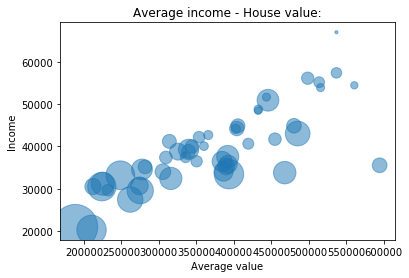

In [75]:
norm_crime = (saskatoon['Monthly crime case'] - saskatoon['Monthly crime case'].min())/(saskatoon['Monthly crime case'].max() -saskatoon['Monthly crime case'].min())
saskatoon.plot(kind='scatter', y='median_total_income', x='single_family_dwelling_avg_value', alpha =0.5, s= norm_crime*2000+10)
# draw a scatter diagram based on median total income and average house price. The bubble show the monthly crime rate
plt.title('Average income - House value:')
plt.ylabel('Income')
plt.xlabel('Average value')
plt.show()

### It is quite obvious that the more higher income , the more expensive the house is. In addition, the crime rate is quite high when house price is less than 350,000

## 4.2 The relationship between Average House RENT - Median Income - Crime rates by neighbourhood 

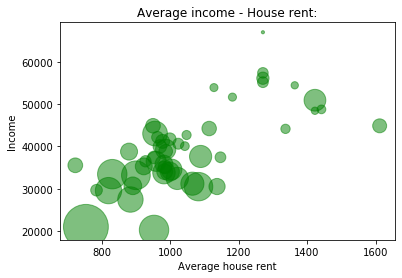

In [76]:
norm_crime = (saskatoon['Monthly crime case'] - saskatoon['Monthly crime case'].min())/(saskatoon['Monthly crime case'].max() -saskatoon['Monthly crime case'].min())

saskatoon.plot(kind='scatter', y='median_total_income', x='average_gross_rent_amount', alpha =0.5, s= norm_crime*2000+10, color='green')

plt.title('Average income - House rent:')
plt.ylabel('Income')
plt.xlabel('Average house rent')
plt.show()

### The average house rent is safe area is over 1,200
## So, based on the information about crime rate, house price, house rent, it should be a good idea to find a house value over 350,000 or rent a house over 1,200 to ensure the safety area

# 4. Cluster neighbourhood based on top venues visited
### With the analysis above, now, we look at the  frequenly visited venues in each neighbourhood to know what characteristics of residents in each area

In [26]:
# set number of clusters
kclusters = 4
saskatoon_grouped_clustering = saskatoon_grouped.drop('neighbourhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(saskatoon_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([2, 1, 2, 3, 2, 1, 2, 2, 2, 2], dtype=int32)

In [27]:
# add clustering labels

neighbourhoods_venues_clustering = neighborhoods_venues_sorted
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighbourhoods_venues_clustering['Cluster Labels'] = kmeans.labels_
neighbourhoods_venues_clustering

,Cluster Labels,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Adelaide/Churchill,Construction & Landscaping,Vietnamese Restaurant,Video Game Store,Coffee Shop,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,Diner,Doctor's Office
1,1,Arbor Creek,Park,Entertainment Service,Shoe Store,Vietnamese Restaurant,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store
2,2,Avalon,Dog Run,Pizza Place,Pub,Liquor Store,Vietnamese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store
3,3,Blairmore Suburban Centre,Pub,Fast Food Restaurant,Vietnamese Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant
4,2,Brevoort Park,Fast Food Restaurant,Steakhouse,Bank,Sandwich Place,Mini Golf,Gym,Brazilian Restaurant,Burger Joint,Restaurant,Pizza Place
5,1,Briarwood,Home Service,Business Service,Park,Vietnamese Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store
6,2,Buena Vista,Bookstore,Playground,Café,Farmers Market,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,Diner
7,2,Caswell Hill,Nightclub,Golf Course,Gym Pool,Hotel,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store
8,2,City Park,Indian Restaurant,Vietnamese Restaurant,Asian Restaurant,Coffee Shop,Hotel,Convenience Store,Lounge,Liquor Store,Jazz Club,Café
9,2,Confederation Park,Fast Food Restaurant,Pizza Place,Gas Station,Indian Restaurant,Italian Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop


In [28]:
saskatoon_merged = saskatoon

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
saskatoon_merged =pd.merge(neighbourhoods_venues_clustering,saskatoon_merged, on ='neighbourhood')
saskatoon_merged

,Cluster Labels,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
0,2,Adelaide/Churchill,Construction & Landscaping,Vietnamese Restaurant,Video Game Store,Coffee Shop,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,Diner,Doctor's Office,365930.0,936,1048,42710,3683.0,52.098655,-106.640908,9.888889
1,1,Arbor Creek,Park,Entertainment Service,Shoe Store,Vietnamese Restaurant,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,515968.0,1548,1128,53950,5147.0,52.134524,-106.564816,7.888889
2,2,Avalon,Dog Run,Pizza Place,Pub,Liquor Store,Vietnamese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,353715.0,1092,963,42190,3379.0,52.094877,-106.656069,15.444444
3,3,Blairmore Suburban Centre,Pub,Fast Food Restaurant,Vietnamese Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,339628.0,1212,987,39310,918.0,52.139473,-106.744521,44.777778
4,2,Brevoort Park,Fast Food Restaurant,Steakhouse,Bank,Sandwich Place,Mini Golf,Gym,Brazilian Restaurant,Burger Joint,Restaurant,Pizza Place,389852.0,997,923,35290,3761.0,52.111061,-106.613617,31.555556
5,1,Briarwood,Home Service,Business Service,Park,Vietnamese Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,560983.0,1493,1364,54490,5356.0,52.109636,-106.564764,6.666667
6,2,Buena Vista,Bookstore,Playground,Café,Farmers Market,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,Diner,313999.0,1017,978,41200,3211.0,52.110815,-106.668258,21.666667
7,2,Caswell Hill,Nightclub,Golf Course,Gym Pool,Hotel,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,248549.0,953,900,33180,3667.0,52.139134,-106.672434,89.000000
8,2,City Park,Indian Restaurant,Vietnamese Restaurant,Asian Restaurant,Coffee Shop,Hotel,Convenience Store,Lounge,Liquor Store,Jazz Club,Café,393626.0,1072,831,33440,4277.0,52.131802,-106.660767,93.444444
9,2,Confederation Park,Fast Food Restaurant,Pizza Place,Gas Station,Indian Restaurant,Italian Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,277385.0,1081,1004,34540,7447.0,52.132548,-106.699931,47.222222


In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(saskatoon_merged['Latitude'], saskatoon_merged['Longitude'], saskatoon_merged['neighbourhood'], saskatoon_merged['Cluster Labels']):
    #print(cluster)
    #print(type(cluster))
   
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label,  color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)       
map_clusters

# Examine each cluster

In [30]:
# Cluster 1 
saskatoon_merged.loc[saskatoon_merged['Cluster Labels'] ==0]

,Cluster Labels,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
36,0,Silverwood Heights,Home Service,Vietnamese Restaurant,Farmers Market,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,Diner,404070.0,1177,1114,44250,10937.0,52.181964,-106.620353,23.333333


In [31]:
# Cluster 2 --> --> Senior area, family-oriented neighbourhood
saskatoon_merged.loc[saskatoon_merged['Cluster Labels'] ==1]

,Cluster Labels,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
1,1,Arbor Creek,Park,Entertainment Service,Shoe Store,Vietnamese Restaurant,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,515968.0,1548,1128,53950,5147.0,52.134524,-106.564816,7.888889
5,1,Briarwood,Home Service,Business Service,Park,Vietnamese Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,560983.0,1493,1364,54490,5356.0,52.109636,-106.564764,6.666667
11,1,Eastview,Park,Diner,Greek Restaurant,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,350410.0,1031,928,36490,3909.0,52.094650,-106.613712,14.666667
20,1,Holiday Park,Park,Campground,Vietnamese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,Diner,231950.0,999,785,29640,1745.0,52.110075,-106.687981,15.444444
29,1,North Park,Pharmacy,Gym / Fitness Center,Construction & Landscaping,Park,Vietnamese Restaurant,Dog Run,Cocktail Bar,Coffee Shop,Convenience Store,Cupcake Shop,309382.0,997,953,37400,2028.0,52.146710,-106.651679,18.111111
37,1,Stonebridge,Park,Ice Cream Shop,Bubble Tea Shop,Vietnamese Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,445701.0,1678,1423,50950,8907.0,52.080408,-106.623111,51.555556
42,1,Wildwood,Park,Greek Restaurant,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,Diner,391933.0,931,1089,37630,7455.0,52.108742,-106.594424,53.333333


In [32]:
# Cluster 3
saskatoon_merged.loc[saskatoon_merged['Cluster Labels'] ==2]

,Cluster Labels,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
0,2,Adelaide/Churchill,Construction & Landscaping,Vietnamese Restaurant,Video Game Store,Coffee Shop,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,Diner,Doctor's Office,365930.0,936,1048,42710,3683.0,52.098655,-106.640908,9.888889
2,2,Avalon,Dog Run,Pizza Place,Pub,Liquor Store,Vietnamese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,353715.0,1092,963,42190,3379.0,52.094877,-106.656069,15.444444
4,2,Brevoort Park,Fast Food Restaurant,Steakhouse,Bank,Sandwich Place,Mini Golf,Gym,Brazilian Restaurant,Burger Joint,Restaurant,Pizza Place,389852.0,997,923,35290,3761.0,52.111061,-106.613617,31.555556
6,2,Buena Vista,Bookstore,Playground,Café,Farmers Market,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,Diner,313999.0,1017,978,41200,3211.0,52.110815,-106.668258,21.666667
7,2,Caswell Hill,Nightclub,Golf Course,Gym Pool,Hotel,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,248549.0,953,900,33180,3667.0,52.139134,-106.672434,89.000000
8,2,City Park,Indian Restaurant,Vietnamese Restaurant,Asian Restaurant,Coffee Shop,Hotel,Convenience Store,Lounge,Liquor Store,Jazz Club,Café,393626.0,1072,831,33440,4277.0,52.131802,-106.660767,93.444444
9,2,Confederation Park,Fast Food Restaurant,Pizza Place,Gas Station,Indian Restaurant,Italian Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,277385.0,1081,1004,34540,7447.0,52.132548,-106.699931,47.222222
10,2,Dundonald,Candy Store,Pizza Place,Playground,Convenience Store,Flower Shop,Entertainment Service,Coffee Shop,Construction & Landscaping,Cupcake Shop,Department Store,344177.0,1231,970,40000,5871.0,52.147457,-106.727039,20.555556
12,2,Erindale,Fast Food Restaurant,Grocery Store,Gym / Fitness Center,Supermarket,Bank,Soccer Stadium,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,432864.0,1118,1442,48790,4446.0,52.145277,-106.577218,9.111111
14,2,Exhibition,Theme Park,Convenience Store,Racetrack,Sports Bar,Vietnamese Restaurant,Entertainment Service,Cocktail Bar,Coffee Shop,Construction & Landscaping,Cupcake Shop,281485.0,959,985,35160,2571.0,52.099758,-106.676394,21.111111


In [33]:
# Cluster 4 --> Young asian area
saskatoon_merged.loc[saskatoon_merged['Cluster Labels'] ==3]

,Cluster Labels,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
3,3,Blairmore Suburban Centre,Pub,Fast Food Restaurant,Vietnamese Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,339628.0,1212,987,39310,918.0,52.139473,-106.744521,44.777778
13,3,Evergreen,Pub,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,Dim Sum Restaurant,Diner,498760.0,1938,1271,56170,3283.0,52.169376,-106.569080,17.111111


# Based on the frequently visited venue, Cluster # 3 seems to neighbourhood which provide a wide variety of services, which can suitable for different lifestyle. Focus on Cluster # 3, I would like see how housing cost, rental fee, safety this neighbourhood is. Which neighbourhood can suitable for family-oriented.

# 5. Cluster Saskatoon neighbourhood 3 based on housing cost, median income, population and crimes rate


In [35]:

saskatoon_cluster2 = saskatoon_merged.loc[saskatoon_merged['Cluster Labels'] ==2].copy()
saskatoon2 = saskatoon_cluster2.loc[:,['single_family_dwelling_avg_value','average_owner_major_payment_amount','average_gross_rent_amount','median_total_income',
                         'Population','Monthly crime case']].copy()
saskatoon2


,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Monthly crime case
0,365930.0,936,1048,42710,3683.0,9.888889
2,353715.0,1092,963,42190,3379.0,15.444444
4,389852.0,997,923,35290,3761.0,31.555556
6,313999.0,1017,978,41200,3211.0,21.666667
7,248549.0,953,900,33180,3667.0,89.000000
8,393626.0,1072,831,33440,4277.0,93.444444
9,277385.0,1081,1004,34540,7447.0,47.222222
10,344177.0,1231,970,40000,5871.0,20.555556
12,432864.0,1118,1442,48790,4446.0,9.111111
14,281485.0,959,985,35160,2571.0,21.111111


In [36]:
kclusters2 = 4
kmeans2 = KMeans(n_clusters=kclusters2, random_state=0).fit(saskatoon2)
kmeans2.labels_[0:10]


array([0, 0, 0, 1, 3, 0, 1, 0, 0, 1], dtype=int32)

In [37]:
labels2 = kmeans2.labels_
saskatoon2["Cluster Labels"] = labels2
saskatoon2

,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Monthly crime case,Cluster Labels
0,365930.0,936,1048,42710,3683.0,9.888889,0
2,353715.0,1092,963,42190,3379.0,15.444444,0
4,389852.0,997,923,35290,3761.0,31.555556,0
6,313999.0,1017,978,41200,3211.0,21.666667,1
7,248549.0,953,900,33180,3667.0,89.000000,3
8,393626.0,1072,831,33440,4277.0,93.444444,0
9,277385.0,1081,1004,34540,7447.0,47.222222,1
10,344177.0,1231,970,40000,5871.0,20.555556,0
12,432864.0,1118,1442,48790,4446.0,9.111111,0
14,281485.0,959,985,35160,2571.0,21.111111,1


In [38]:
saskatoon_cluster2.insert(0, 'Cluster Labels 2', kmeans2.labels_)
saskatoon_cluster2

,Cluster Labels 2,Cluster Labels,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,...,9th Most Common Venue,10th Most Common Venue,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
0,0,2,Adelaide/Churchill,Construction & Landscaping,Vietnamese Restaurant,Video Game Store,Coffee Shop,Convenience Store,Cupcake Shop,Department Store,...,Diner,Doctor's Office,365930.0,936,1048,42710,3683.0,52.098655,-106.640908,9.888889
2,0,2,Avalon,Dog Run,Pizza Place,Pub,Liquor Store,Vietnamese Restaurant,Coffee Shop,Construction & Landscaping,...,Cupcake Shop,Department Store,353715.0,1092,963,42190,3379.0,52.094877,-106.656069,15.444444
4,0,2,Brevoort Park,Fast Food Restaurant,Steakhouse,Bank,Sandwich Place,Mini Golf,Gym,Brazilian Restaurant,...,Restaurant,Pizza Place,389852.0,997,923,35290,3761.0,52.111061,-106.613617,31.555556
6,1,2,Buena Vista,Bookstore,Playground,Café,Farmers Market,Construction & Landscaping,Convenience Store,Cupcake Shop,...,Dim Sum Restaurant,Diner,313999.0,1017,978,41200,3211.0,52.110815,-106.668258,21.666667
7,3,2,Caswell Hill,Nightclub,Golf Course,Gym Pool,Hotel,Entertainment Service,Coffee Shop,Construction & Landscaping,...,Cupcake Shop,Department Store,248549.0,953,900,33180,3667.0,52.139134,-106.672434,89.000000
8,0,2,City Park,Indian Restaurant,Vietnamese Restaurant,Asian Restaurant,Coffee Shop,Hotel,Convenience Store,Lounge,...,Jazz Club,Café,393626.0,1072,831,33440,4277.0,52.131802,-106.660767,93.444444
9,1,2,Confederation Park,Fast Food Restaurant,Pizza Place,Gas Station,Indian Restaurant,Italian Restaurant,Entertainment Service,Coffee Shop,...,Convenience Store,Cupcake Shop,277385.0,1081,1004,34540,7447.0,52.132548,-106.699931,47.222222
10,0,2,Dundonald,Candy Store,Pizza Place,Playground,Convenience Store,Flower Shop,Entertainment Service,Coffee Shop,...,Cupcake Shop,Department Store,344177.0,1231,970,40000,5871.0,52.147457,-106.727039,20.555556
12,0,2,Erindale,Fast Food Restaurant,Grocery Store,Gym / Fitness Center,Supermarket,Bank,Soccer Stadium,Entertainment Service,...,Construction & Landscaping,Convenience Store,432864.0,1118,1442,48790,4446.0,52.145277,-106.577218,9.111111
14,1,2,Exhibition,Theme Park,Convenience Store,Racetrack,Sports Bar,Vietnamese Restaurant,Entertainment Service,Cocktail Bar,...,Construction & Landscaping,Cupcake Shop,281485.0,959,985,35160,2571.0,52.099758,-106.676394,21.111111


In [39]:
import matplotlib.colors as colors
# map saskatoon cluster 2
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters2)
ys = [i + x + (i*x)**2 for i in range(kclusters2)]
colors_array = cm.rainbow(np.linspace(0, 1, kclusters2))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(saskatoon_cluster2['Latitude'], saskatoon_cluster2['Longitude'], saskatoon_cluster2['neighbourhood'], saskatoon_cluster2['Cluster Labels 2']):
    #print(cluster)
    #print(type(cluster))
   
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label,  color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)       
map_clusters

# examine each cluster

In [40]:
# Cluster 1, median area, quite safe
saskatoon_cluster2.loc[saskatoon_cluster2['Cluster Labels 2'] ==0]

,Cluster Labels 2,Cluster Labels,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,...,9th Most Common Venue,10th Most Common Venue,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
0,0,2,Adelaide/Churchill,Construction & Landscaping,Vietnamese Restaurant,Video Game Store,Coffee Shop,Convenience Store,Cupcake Shop,Department Store,...,Diner,Doctor's Office,365930.0,936,1048,42710,3683.0,52.098655,-106.640908,9.888889
2,0,2,Avalon,Dog Run,Pizza Place,Pub,Liquor Store,Vietnamese Restaurant,Coffee Shop,Construction & Landscaping,...,Cupcake Shop,Department Store,353715.0,1092,963,42190,3379.0,52.094877,-106.656069,15.444444
4,0,2,Brevoort Park,Fast Food Restaurant,Steakhouse,Bank,Sandwich Place,Mini Golf,Gym,Brazilian Restaurant,...,Restaurant,Pizza Place,389852.0,997,923,35290,3761.0,52.111061,-106.613617,31.555556
8,0,2,City Park,Indian Restaurant,Vietnamese Restaurant,Asian Restaurant,Coffee Shop,Hotel,Convenience Store,Lounge,...,Jazz Club,Café,393626.0,1072,831,33440,4277.0,52.131802,-106.660767,93.444444
10,0,2,Dundonald,Candy Store,Pizza Place,Playground,Convenience Store,Flower Shop,Entertainment Service,Coffee Shop,...,Cupcake Shop,Department Store,344177.0,1231,970,40000,5871.0,52.147457,-106.727039,20.555556
12,0,2,Erindale,Fast Food Restaurant,Grocery Store,Gym / Fitness Center,Supermarket,Bank,Soccer Stadium,Entertainment Service,...,Construction & Landscaping,Convenience Store,432864.0,1118,1442,48790,4446.0,52.145277,-106.577218,9.111111
16,0,2,Greystone Heights,Park,Pizza Place,Restaurant,Fast Food Restaurant,Paper / Office Supplies Store,Doctor's Office,Chinese Restaurant,...,Coffee Shop,Construction & Landscaping,384471.0,1070,959,36470,2650.0,52.118889,-106.613450,43.777778
18,0,2,Hampton Village,Airport Service,Airport Terminal,Hotel,Inn,Vietnamese Restaurant,Fast Food Restaurant,Convenience Store,...,Department Store,Dim Sum Restaurant,405551.0,1762,1612,44890,7236.0,52.161238,-106.686029,21.777778
21,0,2,Holliston,Coffee Shop,Burger Joint,Grocery Store,Smoothie Shop,Greek Restaurant,Frozen Yogurt Shop,Fast Food Restaurant,...,Camera Store,Pizza Place,392622.0,953,982,35810,3571.0,52.110848,-106.630453,35.333333
24,0,2,Lawson Heights,Coffee Shop,Fast Food Restaurant,Gym,Pizza Place,Vietnamese Restaurant,Smoothie Shop,Liquor Store,...,Sandwich Place,Shopping Mall,419422.0,1139,1024,40650,5146.0,52.168995,-106.639159,13.777778


In [41]:
# Cluster 2 --> median class area, median crime rate
saskatoon_cluster2.loc[saskatoon_cluster2['Cluster Labels 2'] ==1]

,Cluster Labels 2,Cluster Labels,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,...,9th Most Common Venue,10th Most Common Venue,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
6,1,2,Buena Vista,Bookstore,Playground,Café,Farmers Market,Construction & Landscaping,Convenience Store,Cupcake Shop,...,Dim Sum Restaurant,Diner,313999.0,1017,978,41200,3211.0,52.110815,-106.668258,21.666667
9,1,2,Confederation Park,Fast Food Restaurant,Pizza Place,Gas Station,Indian Restaurant,Italian Restaurant,Entertainment Service,Coffee Shop,...,Convenience Store,Cupcake Shop,277385.0,1081,1004,34540,7447.0,52.132548,-106.699931,47.222222
14,1,2,Exhibition,Theme Park,Convenience Store,Racetrack,Sports Bar,Vietnamese Restaurant,Entertainment Service,Cocktail Bar,...,Construction & Landscaping,Cupcake Shop,281485.0,959,985,35160,2571.0,52.099758,-106.676394,21.111111
15,1,2,Fairhaven,Photography Studio,Convenience Store,Art Gallery,Baseball Field,Vietnamese Restaurant,Farmers Market,Construction & Landscaping,...,Department Store,Dim Sum Restaurant,305361.0,1027,984,34020,4970.0,52.122820,-106.730882,27.333333
19,1,2,Haultain,Bookstore,Convenience Store,Asian Restaurant,Salon / Barbershop,Fast Food Restaurant,Construction & Landscaping,Cupcake Shop,...,Dim Sum Restaurant,Diner,325582.0,1173,880,38780,2797.0,52.112013,-106.647483,31.777778
25,1,2,Massey Place,Convenience Store,Grocery Store,Bar,Music Venue,Sandwich Place,Intersection,Shoe Store,...,Asian Restaurant,Thai Restaurant,273931.0,1040,891,30680,3680.0,52.116005,-106.649891,34.444444
27,1,2,Meadowgreen,Paintball Field,Playground,Vietnamese Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,Convenience Store,...,Department Store,Dim Sum Restaurant,261722.0,981,884,27430,4656.0,52.121044,-106.709128,69.888889
28,1,2,Mount Royal,Indian Restaurant,Vietnamese Restaurant,Asian Restaurant,Coffee Shop,Hotel,Convenience Store,Lounge,...,Jazz Club,Café,275070.0,975,820,29540,4946.0,52.131802,-106.660767,74.888889
33,1,2,Queen Elizabeth,Pharmacy,Cupcake Shop,Intersection,Vietnamese Restaurant,Farmers Market,Coffee Shop,Construction & Landscaping,...,Department Store,Dim Sum Restaurant,335764.0,1067,1147,37440,2703.0,52.102678,-106.655749,13.333333
38,1,2,Sutherland,Airport,Pharmacy,Convenience Store,Taco Place,Intersection,Entertainment Service,Coffee Shop,...,Cupcake Shop,Department Store,315913.0,997,1021,32430,5362.0,52.142676,-106.602090,53.777778


In [42]:
# Cluster 3 --> median high incom, high real-estate price
saskatoon_cluster2.loc[saskatoon_cluster2['Cluster Labels 2'] ==2]

,Cluster Labels 2,Cluster Labels,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,...,9th Most Common Venue,10th Most Common Venue,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
17,2,2,Grosvenor Park,Fast Food Restaurant,Asian Restaurant,Steakhouse,Vietnamese Restaurant,Seafood Restaurant,Greek Restaurant,Video Game Store,...,Dim Sum Restaurant,Coffee Shop,594846.0,1034,723,35540,1596.0,52.118073,-106.628675,24.111111
23,2,2,Lakeview,Pizza Place,BBQ Joint,Food Truck,Vietnamese Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,...,Cupcake Shop,Department Store,454991.0,1103,999,41730,7519.0,52.097643,-106.595409,17.777778
30,2,2,Nutana,Grocery Store,Pizza Place,Convenience Store,Pet Store,American Restaurant,Cocktail Bar,Construction & Landscaping,...,Cupcake Shop,Department Store,485318.0,1184,956,43060,5972.0,52.109747,-106.643445,66.111111
34,2,2,River Heights,Park,Pizza Place,Restaurant,Fast Food Restaurant,Paper / Office Supplies Store,Doctor's Office,Chinese Restaurant,...,Coffee Shop,Construction & Landscaping,480416.0,1089,950,44900,4602.0,52.118889,-106.613450,23.777778
39,2,2,The Willows,Golf Course,Vietnamese Restaurant,Farmers Market,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,...,Dim Sum Restaurant,Diner,537131.0,1716,1271,67060,642.0,52.076049,-106.658473,2.000000
40,2,2,Varsity View,Convenience Store,Asian Restaurant,Pub,Salon / Barbershop,Bookstore,Vietnamese Restaurant,Farmers Market,...,Cupcake Shop,Department Store,468055.0,1094,982,33800,3291.0,52.114562,-106.643458,54.888889


In [43]:
# Cluster 4 --> low income, low housing price --> high criminal rates
saskatoon_cluster2.loc[saskatoon_cluster2['Cluster Labels 2'] ==3]

,Cluster Labels 2,Cluster Labels,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,...,9th Most Common Venue,10th Most Common Venue,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
7,3,2,Caswell Hill,Nightclub,Golf Course,Gym Pool,Hotel,Entertainment Service,Coffee Shop,Construction & Landscaping,...,Cupcake Shop,Department Store,248549.0,953,900,33180,3667.0,52.139134,-106.672434,89.000000
22,3,2,King George,Pub,Asian Restaurant,Indian Restaurant,Lounge,Coffee Shop,Hotel,Sandwich Place,...,Sporting Goods Shop,Vietnamese Restaurant,211937.0,888,1137,30510,2147.0,52.130198,-106.663664,29.000000
26,3,2,Mayfair,Vietnamese Restaurant,Bakery,Fast Food Restaurant,Construction & Landscaping,Convenience Store,Cupcake Shop,Department Store,...,Diner,Doctor's Office,223842.0,889,1083,30480,2857.0,52.144236,-106.682924,87.222222
32,3,2,Pleasant Hill,Fast Food Restaurant,Coffee Shop,Pizza Place,Indian Restaurant,Italian Restaurant,Entertainment Service,Construction & Landscaping,...,Cupcake Shop,Department Store,188364.0,855,754,20960,5471.0,52.126989,-106.701303,215.444444
35,3,2,Riversdale,Coffee Shop,Chinese Restaurant,Farmers Market,Gluten-free Restaurant,Music Store,Department Store,Pizza Place,...,Café,Restaurant,210067.0,734,953,20230,2669.0,52.125407,-106.677879,93.333333
41,3,2,Westmount,Fast Food Restaurant,Caribbean Restaurant,Ice Cream Shop,Motel,Farmers Market,Construction & Landscaping,Convenience Store,...,Department Store,Dim Sum Restaurant,224980.0,867,1065,31180,2805.0,52.132621,-106.686554,58.111111


# 6. Summary 
### Based on detailed information of each cluster (After clustering most frequently visited areas with combination of other features: housing price, income, crime rate, It seems that the following areas are good and safe for new comers

In [77]:
# Cluster 3 --> median high incom, high real-estate price
saskatoon_cluster2.loc[saskatoon_cluster2['Cluster Labels 2'] ==2]

,Cluster Labels 2,Cluster Labels,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,...,9th Most Common Venue,10th Most Common Venue,single_family_dwelling_avg_value,average_owner_major_payment_amount,average_gross_rent_amount,median_total_income,Population,Latitude,Longitude,Monthly crime case
17,2,2,Grosvenor Park,Fast Food Restaurant,Asian Restaurant,Steakhouse,Vietnamese Restaurant,Seafood Restaurant,Greek Restaurant,Video Game Store,...,Dim Sum Restaurant,Coffee Shop,594846.0,1034,723,35540,1596.0,52.118073,-106.628675,24.111111
23,2,2,Lakeview,Pizza Place,BBQ Joint,Food Truck,Vietnamese Restaurant,Entertainment Service,Coffee Shop,Construction & Landscaping,...,Cupcake Shop,Department Store,454991.0,1103,999,41730,7519.0,52.097643,-106.595409,17.777778
30,2,2,Nutana,Grocery Store,Pizza Place,Convenience Store,Pet Store,American Restaurant,Cocktail Bar,Construction & Landscaping,...,Cupcake Shop,Department Store,485318.0,1184,956,43060,5972.0,52.109747,-106.643445,66.111111
34,2,2,River Heights,Park,Pizza Place,Restaurant,Fast Food Restaurant,Paper / Office Supplies Store,Doctor's Office,Chinese Restaurant,...,Coffee Shop,Construction & Landscaping,480416.0,1089,950,44900,4602.0,52.118889,-106.613450,23.777778
39,2,2,The Willows,Golf Course,Vietnamese Restaurant,Farmers Market,Coffee Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,...,Dim Sum Restaurant,Diner,537131.0,1716,1271,67060,642.0,52.076049,-106.658473,2.000000
40,2,2,Varsity View,Convenience Store,Asian Restaurant,Pub,Salon / Barbershop,Bookstore,Vietnamese Restaurant,Farmers Market,...,Cupcake Shop,Department Store,468055.0,1094,982,33800,3291.0,52.114562,-106.643458,54.888889


### Lakeview area might be the good choice in terms of affordable house price, rent amound and low crime rates

In [86]:
from IPython.display import Image
imgUrl = 'lakeview.jpg'            # setup path and filename
img = Image(url=imgUrl)              # create the image object
img 

In [87]:
imgUrl = 'Lakeview house.jpg'            # setup path and filename
img = Image(url=imgUrl)              # create the image object
img 